# Use Deep Learning to Clone Driving Behavior

## Submission criterias

### Quality of Code
- Is the code functional?
    - TODO The model provided can be used to successfully operate the simulation.
- Is the code usable and readable?
    - TODO The code in model.py uses a Python generator, if needed, to generate data for training rather than storing the training data in memory. 
    - TODO: The model.py code is clearly organized and comments are included where needed.
    
### Model Architecture and Training Strategy
- Has an appropriate model architecture been employed for the task?
    * TODO: The neural network uses convolution layers with appropriate filter sizes. 
    * TODO: Layers exist to introduce nonlinearity into the model. 
    * TODO: The data is normalized in the model.
    
- Has an attempt been made to reduce overfitting of the model?
    - TODO: Train/validation/test splits have been used, and the model uses dropout layers or other methods to reduce overfitting.
- Have the model parameters been tuned appropriately?
    - TODO: Learning rate parameters are chosen with explanation, or an Adam optimizer is used.
- Is the training data chosen appropriately?
    - TODO: Training data has been chosen to induce the desired behavior in the simulation (i.e. keeping the car on the track).
    
### Architecture and Training Documentation
- Is the solution design documented?
    - The README thoroughly discusses the approach taken for deriving and designing a model architecture fit for solving the given problem.
- Is the model architecture documented?
    - The README provides sufficient details of the characteristics and qualities of the architecture, such as the type of model used, the number of layers, the size of each layer. Visualizations emphasizing particular qualities of the architecture are encouraged.
- Is the creation of the training dataset and training process documented?
    - The README describes how the model was trained and what the characteristics of the dataset are. Information such as how the dataset was generated and examples of images from the dataset should be included.
    
### Simulation
- Is the car able to navigate correctly on test data?
    - No tire may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle).

## The list of files to submit:
- model.py - The script used to create and train the model.
- [drive.py](./drive.py) - The script to drive the car. You can feel free to resubmit the original drive.py or make modifications and submit your modified version.
- model.json - The model architecture.
- model.h5 - The model weights.
- [README.md](./README.md) - explains the structure of your network and training approach. While we recommend using English for good practice, writing in any language is acceptable (reviewers will translate). There is no minimum word count so long as there are complete descriptions of the problems and the strategies. See the rubric for more details about the expectations.

## 1. Files in this repo
* `model.py`: Python script to import data, train model and save model.
* `model.json`: Model architecture.
* `model.h5`: Model weights (Large file, > 300MB).
* `drive.py`: Python script that tells the car in the simulator how to drive
* `data/`: file with training data
    * Attributes such as 'steering angle' mapped to image paths in `driving_log.csv`.
    * Images in `IMG/`.


## Understanding data


### Augmentation
We used the same augmentation scheme as before. The augmentations applied were,
#### Brightness augmentation: 
Changing brightness of the input image by scaling the V channel between .75 and 1.25 in the transformed HSV image.
#### Using left and right camera images: 
To simulate the effect of car wandering off to the side, and recovering. We added a small angle .25 to the left camera and subtracted a small angle of 0.25 from the right camera. The main idea being the left camera has to move right to get to center, and right camera has to move left.
#### Horizontal and vertical shifts:
We randomly shifted the camera images horizontally to simulate the effect of car being at different positions on the lane, and added an offset corresponding to the shift to the steering angle. We also shifted the images vertically by a random number to simulate the effect of driving up or down a slope.
#### Flipping: 
We also flipped images at random and changed the sign of the predicted angle to simulate driving in the opposite direction.

### Preprocessing
We cropped the top 1/5 and bottom 25 pixels of the image, to remove the blue protion from the sky and hood of the car from the image. We further resized the image to 200 by 66 to match the NVIDIA’s image format. After augmentation and preprocessing the images generated from 1 image change as shown below.
![](https://cdn-images-1.medium.com/max/800/1*vLCKp-VcTl9-3Dt2Lgj3aA.png)


TODO show angles distributions with images ![](https://cdn-images-1.medium.com/max/800/1*FB9Z4a0MUKs0tsD9PE6eYQ.png)

### Objective to building model
The goal is the car to drive within the lane lines, so the model needs to recognise lane lines from the camera images.
TODO: Copy the Nvidia pipeline. It works :) And it's not too complex.

### Preprocessing
Re-size the input image. I was able to size the image down by 2, reducing the number of pixels by 4. This really helped speed up model training and did not seem to impact the accuracy.

### Warning!
drive.py sends RGB images to the model; cv2.imread() reads images in BGR format!!!!
Fixed the bug and passed the 2 sharp corners at the first attempt lol.


### Starting out

##### Train 3 images 
When you're starting out, pick three images from the .csv file, one with negative steering, one with straight, and one with right steering. Train a model with just those three images and see if you can get it to predict them correctly. This will tell you that your model is good and your turn-around time will be very quick. Then you can start adding more training data

##### Train on provided data 
There is 8037 snapshots provided in the training set. Use it to train the network. 


Here is [Github project](https://github.com/vxy10/P3-BehaviorCloning) of Vivek Yadav [post 1](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.vbfk0tp2p) and [post 2](https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.xrn3giarp)

Try out [Comma.ai model](https://github.com/commaai/research/blob/master/train_steering_model.py)


In [ ]:
# https://github.com/commaai/research/blob/master/train_steering_model.py
"""
Steering angle prediction model
"""
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

from server import client_generator


def gen(hwm, host, port):
  for tup in client_generator(hwm=hwm, host=host, port=port):
    X, Y, _ = tup
    Y = Y[:, -1]
    if X.shape[1] == 1:  # no temporal context
      X = X[:, -1]
    yield X, Y


def get_model(time_len=1):
  ch, row, col = 3, 160, 320  # camera format

  model = Sequential()
  model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))

  model.compile(optimizer="adam", loss="mse")

  return model


if __name__ == "__main__":
  parser = argparse.ArgumentParser(description='Steering angle model trainer')
  parser.add_argument('--host', type=str, default="localhost", help='Data server ip address.')
  parser.add_argument('--port', type=int, default=5557, help='Port of server.')
  parser.add_argument('--val_port', type=int, default=5556, help='Port of server for validation dataset.')
  parser.add_argument('--batch', type=int, default=64, help='Batch size.')
  parser.add_argument('--epoch', type=int, default=200, help='Number of epochs.')
  parser.add_argument('--epochsize', type=int, default=10000, help='How many frames per epoch.')
  parser.add_argument('--skipvalidate', dest='skipvalidate', action='store_true', help='Multiple path output.')
  parser.set_defaults(skipvalidate=False)
  parser.set_defaults(loadweights=False)
  args = parser.parse_args()

  model = get_model()
  model.fit_generator(
    gen(20, args.host, port=args.port),
    samples_per_epoch=10000,
    nb_epoch=args.epoch,
    validation_data=gen(20, args.host, port=args.val_port),
    nb_val_samples=1000
  )
  print("Saving model weights and configuration file.")

  if not os.path.exists("./outputs/steering_model"):
      os.makedirs("./outputs/steering_model")

  model.save_weights("./outputs/steering_model/steering_angle.keras", True)
  with open('./outputs/steering_model/steering_angle.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

#### [NVIDIA model](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) 

<img src="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture.png" width="400">

<p><center>NVIDIA model architecture, taken from [End to end learning for self-driving cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)</center>

![](https://cdn-images-1.medium.com/max/2000/1*lGH4OFwoUfj5pX2OWLhGkg.png)
We did not use dropouts or maxpooling in our architecture to remain true to NVIDIA model. 

We used exponential leaky units (ELU) for activation functions, because ELUs have smoother derivatives at zero, and hence are expected to be slighly better for predicted continuous values. We tested the model with rectified linear units (ReLU) too, and noticed minimal performance difference between the two networks.


## TODO: provide correct model without dropouts

we choose ELU() over ReLu because ELUs have [improved learning characteristics](https://arxiv.org/pdf/1511.07289v1.pdf) compared to the units with other activation functions. In contrast to ReLUs, ELUs have negative values which allows them to push mean unit activations closer to zero.

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
def nvidia_model(summary=True):
    init = 'he_normal'
    model = Sequential()
    # TODO:  checkif we can do mean subtraction
    model.add(Lambda(lambda z: z / 127.5 - 1., input_shape=[66, 200, 3]))
    
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))

    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))


    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))


    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))


    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))


    model.add(Flatten())
#    model.add(Dropout(0.2))

    model.add(Dense(1164, init=init))
    model.add(ELU())
#    model.add(Dropout(0.5))

    model.add(Dense(100, init=init))
    model.add(ELU())
#    model.add(Dropout(0.5))

    model.add(Dense(50, init=init))
    model.add(ELU())

    model.add(Dense(10, init=init))
    model.add(ELU())

    model.add(Dense(1, init=init))
    model.add(ELU())
    
    model.compile(optimizer="adam", loss="mse")
    
    if summary:
        model.summary()
    
    return model

model = nvidia_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

In [18]:
NVIDIA_H, NVIDIA_W = 66, 200

CONFIG = {
    'batchsize': 512,
    'input_width': NVIDIA_W,
    'input_height': NVIDIA_H,
    'input_channels': 3,
    'delta_correction': 0.25,
    'augmentation_steer_sigma': 0.2,
    'augmentation_value_min': 0.2,
    'augmentation_value_max': 1.5,
    'bias': 0.8,
    'crop_height': range(20, 140)
}

def get_nvidia_model(summary=True):
    init = 'glorot_uniform'

    input_frame = Input(shape=(66, 200, 3))

    # input normalization
    ''' The first layer of the network performs image normalization. The normalizer is hard-coded 
    and is not adjusted in the learning process. 
    Performing normalization in the network allows the normalization scheme to be altered with 
    the network architecture, and to be accelerated via GPU processing.'''
    x = Lambda(lambda z: z / 127.5 - 1.)(input_frame)

    ''' The convolutional layers are designed to perform feature extraction, and are chosen empirically 
    through a series of experiments that vary layer configurations. 
    We then use strided convolutions in the first three convolutional layers with a 2×2 stride and a 5×5 kernel'''
    x = Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    
    '''We use a non-strided convolution with a 3×3 kernel size in the final two convolutional layers.'''
    x = Convolution2D(64, 3, 3, border_mode='valid', init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(64, 3, 3, border_mode='valid', init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    
    ''' We follow the five convolutional layers with three fully connected layers, leading to a final 
    output control value which is the inverse-turning-radius. 
    The fully connected layers are designed to function as a controller for steering, but we noted 
    that by training the system end-to-end, it is not possible to make a clean break between which 
    parts of the network function primarily as feature extractor, and which serve as controller.'''
    x = Dense(1164, init=init)(x)
    x = ELU()(x)    
    x = Dropout(0.5)(x)

    x = Dense(100, init=init)(x)
    x = ELU()(x)    
    x = Dropout(0.5)(x)
    
    x = Dense(50, init=init)(x)
    x = ELU()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, init=init)(x)
    x = ELU()(x)
    
    out = Dense(1, init=init)(x)

    model = Model(input=input_frame, output=out)

    if summary:
        model.summary()

    return model


In [19]:
model = get_nvidia_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 66, 200, 3)    0           input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 31, 98, 24)    1824        lambda_3[0][0]                   
____________________________________________________________________________________________________
elu_19 (ELU)                     (None, 31, 98, 24)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

## Data visualization

In [12]:
def visualize_steering_distribution(train_data):
    """
    Visualize the training ground truth distribution "as provided"
    :param train_data: list of udacity training data
    :return:
    """
    train_steering = np.float32(np.array(train_data)[:, 3])
    plt.title('Steering angle distribution in training data')
    plt.hist(train_steering, 100, normed=0, facecolor='green', alpha=0.75)
    plt.ylabel('# frames'), plt.xlabel('steering angle')
    plt.show()


def visualize_bias_parameter_effect(train_data):
    """
    Visualize how the 'bias' parameter influences the ground truth distribution
    :param train_data:
    :return:
    """
    biases = np.linspace(start=0., stop=1., num=5)
    fig, axarray = plt.subplots(len(biases))
    plt.suptitle('Effect of bias parameter on steering angle distribution', fontsize=14, fontweight='bold')
    for i, ax in enumerate(axarray.ravel()):
        b = biases[i]
        x_batch, y_batch = load_data_batch(train_data, batchsize=1024, augment_data=True, bias=b)
        ax.hist(y_batch, 50, normed=1, facecolor='green', alpha=0.75)
        ax.set_title('Bias: {:02f}'.format(b))
        ax.axis([-1., 1., 0., 2.])
    plt.tight_layout(pad=2, w_pad=0.5, h_pad=1.0)
    plt.show()


In [2]:
# NVIDIA model
import cv2
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, ELU, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger

NVIDIA_H, NVIDIA_W = 66, 200

CONFIG = {
    'batchsize': 512,
    'input_width': NVIDIA_W,
    'input_height': NVIDIA_H,
    'input_channels': 3,
    'delta_correction': 0.25,
    'augmentation_steer_sigma': 0.2,
    'augmentation_value_min': 0.2,
    'augmentation_value_max': 1.5,
    'bias': 0.8,
    'crop_height': range(20, 140)
}

def preprocess(frame_bgr, verbose=False):
    # set training images resized shape
    h, w = CONFIG['input_height'], CONFIG['input_width']

    # crop image (remove useless information)
    frame_cropped = frame_bgr[CONFIG['crop_height'], :, :]

    # resize image
    frame_resized = cv2.resize(frame_cropped, dsize=(w, h))

    # eventually change color space
    if CONFIG['input_channels'] == 1:
        frame_resized = np.expand_dims(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2YUV)[:, :, 0], 2)

    if verbose:
        plt.figure(1), plt.imshow(cv2.cvtColor(frame_bgr, code=cv2.COLOR_BGR2RGB))
        plt.figure(2), plt.imshow(cv2.cvtColor(frame_cropped, code=cv2.COLOR_BGR2RGB))
        plt.figure(3), plt.imshow(cv2.cvtColor(frame_resized, code=cv2.COLOR_BGR2RGB))
        plt.show()

    return frame_resized.astype('float32')


def load_data_batch(data, batchsize=CONFIG['batchsize'], data_dir='data', augment_data=True, bias=0.5):
    # set training images resized shape
    h, w, c = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']

    # prepare output structures
    X = np.zeros(shape=(batchsize, h, w, c), dtype=np.float32)
    y_steer = np.zeros(shape=(batchsize,), dtype=np.float32)
    y_throttle = np.zeros(shape=(batchsize,), dtype=np.float32)

    # shuffle data
    shuffled_data = shuffle(data)

    loaded_elements = 0
    while loaded_elements < batchsize:

        ct_path, lt_path, rt_path, steer, throttle, brake, speed = shuffled_data.pop()

        # cast strings to float32
        steer = np.float32(steer)
        throttle = np.float32(throttle)
'''
One predominant problem in steering prediction is that even if the model predicts really really well, 
the model is bound to make a non zero error on it’s prediction. This means that over time the model 
will drift off from center. Since we are only training the model to drive correctly and not training 
the model how to recover (something that we humans know instinctively), the model is handicapped.

To offset this problem, we choose images randomly between left, right or center images by doing 
the following. The approach is to add / subtract a static offset from the angle when choosing 
the left / right image. To get a smoother drive, we can add / subtract an offset that’s weighted 
by the magnitude of the angle. But this biases the model towards zeros again and is a design tradeoff. 
I chose the simple static offsets. This simulates the model drifting off the center and trains the model 
to recover from it’s mistakes. This also gives us a lot more data to work with than by just using the 
center images alone.
img_choice = np.random.randint(3)
if img_choice == 0:
    img_path = os.path.join(PATH, df.left.iloc[idx].strip())
    angle += OFF_CENTER_IMG
elif img_choice == 1:
    img_path = os.path.join(PATH, df.center.iloc[idx].strip())
else:
    img_path = os.path.join(PATH, df.right.iloc[idx].strip())
    angle -= OFF_CENTER_IMG
'''
        # randomly choose which camera to use among (central, left, right)
        # in case the chosen camera is not the frontal one, adjust steer accordingly
        delta_correction = CONFIG['delta_correction']
        camera = random.choice(['frontal', 'left', 'right'])
        if camera == 'frontal':
            frame = preprocess(cv2.imread(join(data_dir, ct_path.strip())))
            steer = steer
        elif camera == 'left':
            frame = preprocess(cv2.imread(join(data_dir, lt_path.strip())))
            steer = steer + delta_correction
        elif camera == 'right':
            frame = preprocess(cv2.imread(join(data_dir, rt_path.strip())))
            steer = steer - delta_correction

        if augment_data:
            '''One easy way to get more data is to just flip the image around the horizontal axis 
            and flip the sign on the angle as well. We instantly get twice the data and we don’t 
            inadvertently bias the model towards any one direction.
            if np.random.randint(2) == 0:
                img = np.fliplr(img)
                new_angle = -new_angle
            '''
            # mirror images with chance=0.5
            if random.choice([True, False]):
                frame = frame[:, ::-1, :]
                steer *= -1.
                
            # perturb slightly steering direction
            steer += np.random.normal(loc=0, scale=CONFIG['augmentation_steer_sigma'])
            # if color images, randomly change brightness
            if CONFIG['input_channels'] == 3:
                frame = cv2.cvtColor(frame, code=cv2.COLOR_BGR2HSV)
                frame[:, :, 2] *= random.uniform(CONFIG['augmentation_value_min'], CONFIG['augmentation_value_max'])
                frame[:, :, 2] = np.clip(frame[:, :, 2], a_min=0, a_max=255)
                frame = cv2.cvtColor(frame, code=cv2.COLOR_HSV2BGR)
        # check that each element in the batch meet the condition
        steer_magnitude_thresh = np.random.rand()
        if (abs(steer) + bias) < steer_magnitude_thresh:
            pass  # discard this element
        else:
            X[loaded_elements] = frame
            y_steer[loaded_elements] = steer
            loaded_elements += 1

    if K.backend() == 'theano':
        X = X.transpose(0, 3, 1, 2)

    return X, y_steer


def generate_data_batch(data, batchsize=CONFIG['batchsize'], data_dir='data', augment_data=True, bias=0.5):
    # set training images resized shape
    h, w, c = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']

    while True:
        # prepare output structures
        X = np.zeros(shape=(batchsize, h, w, c), dtype=np.float32)
        y_steer = np.zeros(shape=(batchsize,), dtype=np.float32)
        y_throttle = np.zeros(shape=(batchsize,), dtype=np.float32)

        # shuffle data
        shuffled_data = shuffle(data)

        loaded_elements = 0
        while loaded_elements < batchsize:

            ct_path, lt_path, rt_path, steer, throttle, brake, speed = shuffled_data.pop()

            # cast strings to float32
            steer = np.float32(steer)
            throttle = np.float32(throttle)

            # randomly choose which camera to use among (central, left, right)
            # in case the chosen camera is not the frontal one, adjust steer accordingly
            delta_correction = CONFIG['delta_correction']
            camera = random.choice(['frontal', 'left', 'right'])
            if camera == 'frontal':
                frame = preprocess(cv2.imread(join(data_dir, ct_path.strip())))
                steer = steer
            elif camera == 'left':
                frame = preprocess(cv2.imread(join(data_dir, lt_path.strip())))
                steer = steer + delta_correction
            elif camera == 'right':
                frame = preprocess(cv2.imread(join(data_dir, rt_path.strip())))
                steer = steer - delta_correction

            if augment_data:

                # mirror images with chance=0.5
                if random.choice([True, False]):
                    frame = frame[:, ::-1, :]
                    steer *= -1.

                # perturb slightly steering direction
                steer += np.random.normal(loc=0, scale=CONFIG['augmentation_steer_sigma'])

                # if color images, randomly change brightness
                if CONFIG['input_channels'] == 3:
                    frame = cv2.cvtColor(frame, code=cv2.COLOR_BGR2HSV)
                    frame[:, :, 2] *= random.uniform(CONFIG['augmentation_value_min'], CONFIG['augmentation_value_max'])
                    frame[:, :, 2] = np.clip(frame[:, :, 2], a_min=0, a_max=255)
                    frame = cv2.cvtColor(frame, code=cv2.COLOR_HSV2BGR)

            # check that each element in the batch meet the condition
            steer_magnitude_thresh = np.random.rand()
            if (abs(steer) + bias) < steer_magnitude_thresh:
                pass  # discard this element
            else:
                X[loaded_elements] = frame
                y_steer[loaded_elements] = steer
                loaded_elements += 1

        if K.backend() == 'theano':
            X = X.transpose(0, 3, 1, 2)

        yield X, y_steer

        


def split_train_val(csv_driving_data):

    with open(csv_driving_data, 'r') as f:
        reader = csv.reader(f)
        driving_data = [row for row in reader][1:]

    train_data, val_data = train_test_split(driving_data, test_size=0.2, random_state=1)

    return train_data, val_data

### Main
if __name__ == '__main__':
    
    train_data, val_data = split_train_val(csv_driving_data='data/driving_log.csv')
    x_batch, y_batch = load_data_batch(train_data)
    nvidia_net = get_nvidia_model(summary=True)
    opt = Adam(lr=1e-3)
    nvidia_net.compile(optimizer=opt, loss='mse')

    # json dump of model architecture
    with open('logs/model.json', 'w') as f:
        f.write(nvidia_net.to_json())

    checkpointer = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.3f}.hdf5')
    logger = CSVLogger(filename='logs/history.csv')

    nvidia_net.fit_generator(generator=generate_data_batch(train_data, augment_data=True, bias=CONFIG['bias']),
                         samples_per_epoch=300*CONFIG['batchsize'],
                         nb_epoch=50,
                         validation_data=generate_data_batch(val_data, augment_data=False, bias=1.0),
                         nb_val_samples=100*CONFIG['batchsize'],
                         callbacks=[checkpointer, logger])

ImportError: No module named 'load_data'

Here is [VGG keras model](https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py) 

In [11]:
# https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py
"""VGG16 model for Keras.

# Reference

- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K


def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results
#from imagenet_utils import decode_predictions, preprocess_input, _obtain_input_shape


TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          classes=1000):
    """Instantiate the VGG16 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `tf` dim ordering)
            or `(3, 224, 244)` (with `th` dim ordering).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      dim_ordering=K.image_dim_ordering(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                                      ``````````````'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

# Solution
 0. Collecting data.
 >Collecting data on my own was tortuously difficult considering that my choices were limited between a keyboard or a steam controller to control the simulator. I struggled fruitlessly for over a week to collect the data (although, I’ve to admit that playing with the simulator was a lot of fun to begin with). But this gave me a chance to understand just how important the process of collecting the data is.
 1. Importing packages
 
 3. Loading data
 
 4. Data stats + Plotting data distribution
    - Angle over time (provided)
      > We can see that the data set collected some very sharp turns in the middle, but is otherwise pretty evenly distributed.
    - Angle distribution (use histogram from previous assignment)
      > And we can see that it holds good for this dataset as well. HUGE number of zeros and very very few of all other data. This is definitely going to bias our model towards predicting 0s, if we go ahead as it is.
    - Angle difference
      > Let’s also see, if we’ve big jumps in the angles over time (like it would if the data were to be recorded via keyboard). Note that recording from an actual steering wheel, we can expect the angle difference between subsequent samples to be quite uniform.
 
 2. ~~Functions to calculate moving average and compute butterworth filter.~~
 
 5. ~~Removing data with speed below .25~~
 
 5. Plot images for all angle bins
 > Finally, let’s plot some sample images from the data for each angle bin. I’m just splitting all the angles into 21 bins of 0.1 size.
 
 6. Augmentation (obtaining more training data is a tedious process because of the keyboard `TODO: add more reasons...`  
     1. Including LR images.
     > ** Plot images side by side. We need to understand how to use left and right cameras **
     2. Brightness augmentation
     3. Shifting left/right and up/down.
     > We randomly shifted the camera images horizontally to simulate the effect of car being at different positions on the lane, and added an offset corresponding to the shift to the steering angle. We also shifted the images vertically by a random number to simulate the effect of driving up or down a slope.
     ** A better solution could be generating a wide angle / panorama image and do several crops with some offset ** 
     4. Flipping images
     > One easy way to get more data is to just flip the image around the horizontal axis and flip the sign on the angle as well. We instantly get twice the data and we don’t inadvertently bias the model towards any one direction.
 
 6. Regularization
    We take care of regularization in three ways 
    - We augment the data heavily. This more than anything else allows the model to generalize.
    - We add dropouts in all the fully connected layers.
    - We split the training set to training and cross validation to control the number of epochs in training. We split a small size (BATCH size) of data as validation data and use that to control if we are acutely overfitting the data
 
 7. Cropping and resizing (Note: Depends on the model)
 
 8. Keras generator and subsampling
 
 9. Model architecture
 
 10. Training
 > We trained the model using a keras generator that took in data frame with paths to image and returned a specified number of training image and steering angles. We programmed the generator to drop training samples with smaller angles with a tunable probability input. This was done to avoid bias for going straight. 
 
 11. Saving model
 

In [3]:
### Importing packages. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math
from scipy.misc import imread

## Loading data

In [4]:
# Loading data
csv_path = 'data/driving_log.csv'
data_files_s = pd.read_csv(csv_path, 
    header=0,
    names=['center','left','right','steer','throttle','break','speed'],
    index_col = False)
data_files_s['direction'] = pd.Series('s', index=data_files_s.index)
print('number of data files: ', len(data_files_s))

steer = np.array(data_files_s.steer)


number of data files:  8036


### Angle over time 

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


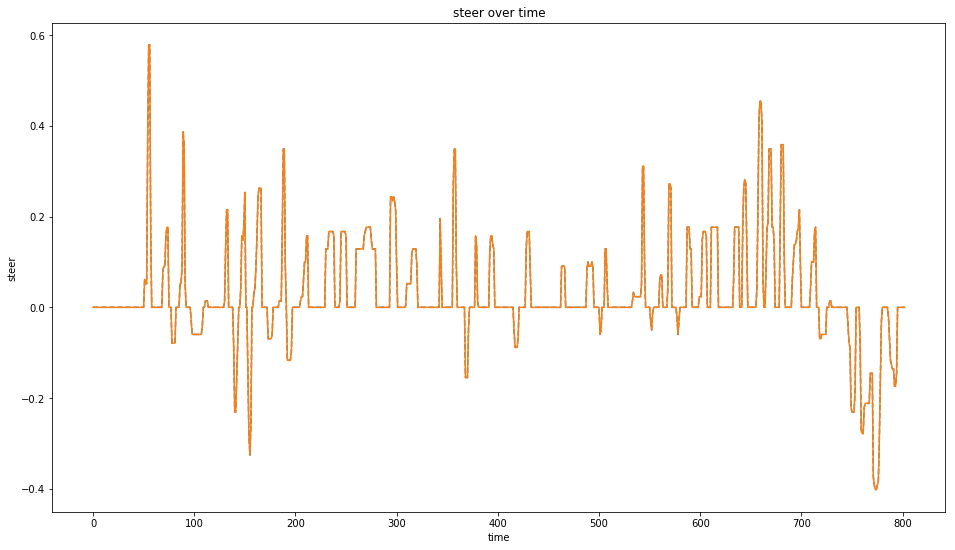

In [5]:
# plot
FRAMES_PER_SECOND = 10
len_plt = len(data_files_s) / FRAMES_PER_SECOND 
#200

def plot_x_over_time(x, length, label):
    rev = np.array(x,dtype=np.float32)
    t_s = np.arange(len(rev))
    x_s = np.array(x)
    y_s = rev
    sm_s = rev
    plt.rcParams["figure.figsize"]= [16, 9]
    plt.plot(t_s[0:len_plt],x_s[0:len_plt],'--',t_s[0:len_plt],y_s[0:len_plt]);
    plt.title(label +  ' over time')
    plt.xlabel('time')
    plt.ylabel(label)
    plt.show()
    
plot_x_over_time(data_files_s.steer, len_plt, 'steer')
# plot_x_over_time(data_files_s.speed, len_plt, 'speed')
# plot_x_over_time(data_files_s.throttle, len_plt, 'throttle')
# plot_x_over_time(data_files_s['break'], len_plt, 'breaks')


rev_steer_s = np.array(data_files_s.steer,dtype=np.float32)
steer_sm_s = rev_steer_s
data_files_s['steer_sm'] = pd.Series(steer_sm_s, index=data_files_s.index)


In [6]:
# Do we really need to filter by throttle or speed?
ind = data_files_s['throttle'] > 0
data_files_filtered = data_files_s[ind].reset_index()
len(data_files_filtered)

7306

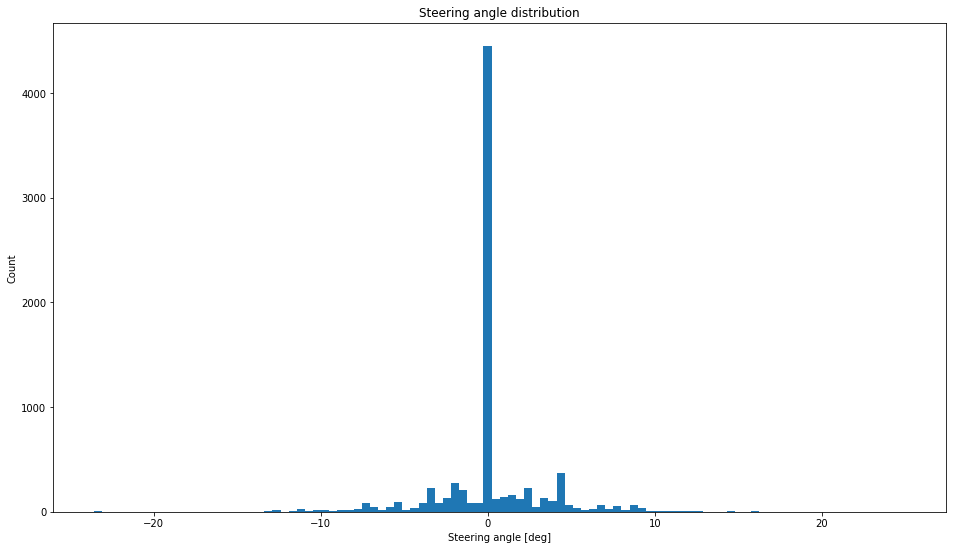

In [7]:
plt.hist(steer*25, bins=100)
plt.title('Steering angle distribution')
plt.xlabel('Steering angle [deg]')
plt.ylabel('Count')
plt.show()

In [17]:
def process_newimage_file(name):
    image = imread(name)
    image = image/255. - .5
    return image

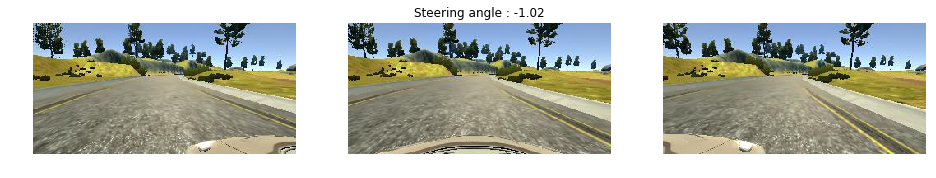

In [22]:

t_s = np.arange(len(rev_steer_s))
x_s = np.array(data_files_s.steer)
y_s = rev_steer_s

ind_num = 4129

image_c = process_newimage_file('data/' + data_files_s['center'][ind_num].strip())
image_r = process_newimage_file('data/' + data_files_s['right'][ind_num].strip())
image_l = process_newimage_file('data/' + data_files_s['left'][ind_num].strip())
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c+.5);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(y_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r+.5);
plt.axis('off');

In [ ]:
def image_generator(driving_log, data_path, normalizer=255.0, steering_shift=2., steering_max=25.):
    driving_log = driving_log.sample(frac=1).reset_index(drop=True)
    for index, row in driving_log.iterrows():
        fname  = os.path.basename(row['center'])
        fname1 = os.path.basename(row['left'])
        fname2 = os.path.basename(row['right'])

        # Normalized YUV
        img  = imread(data_path+'IMG/'+fname)
        img1 = imread(data_path+'IMG/'+fname1)
        img2 = imread(data_path+'IMG/'+fname2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2YUV)
        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2YUV)
        
        yield img, np.float32(row['steer'])
        yield img1, np.float32(row['steer'])+steering_shift/steering_max
        yield img2, np.float32(row['steer'])-steering_shift/steering_max
        
img_gen = image_generator(data_files_s, 'data/')  
n = len(list(img_gen))
m = 2
print('num images', n, 'm',m)

In [ ]:
# Test out cropping out region of interest
plt.rcParams["figure.figsize"] = (10,10)

img, angle = next(img_gen)
img, angle = next(img_gen)

img, angle = next(img_gen)
img, angle = next(img_gen)

img, angle = next(img_gen)


img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB).astype(np.uint8)
plt.imshow(img[60:140,40:280])
plt.xlabel('Before resizing')

plt.figure()
plt.imshow(cv2.resize(img[60:140,40:280], (200,66)))
plt.xlabel('After resizing')
plt.show()
